In [41]:
from collections import OrderedDict
import numpy as np
import scipy
import matplotlib.pyplot as plt
%matplotlib inline

import os, sys
import networkx as nx

In [2]:
libpath = os.path.abspath('..')
if libpath not in sys.path:
    sys.path.append(libpath)

In [3]:
from qubitrbm.qaoa import QAOA
from qubitrbm.optimize import Optimizer
from qubitrbm.rbm import RBM
from qubitrbm.utils import exact_fidelity

## The setup

Define a graph to run QAOA on:

In [4]:
G = nx.random_regular_graph(d=3, n=12, seed=12345)

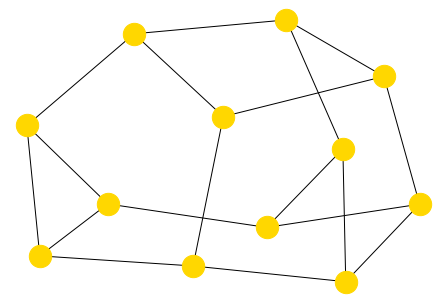

In [5]:
nx.draw_kamada_kawai(G, node_color='gold', node_size=500)

For $p>1$, provided we have a small graph, we can find optimal angles exactly:

In [6]:
qaoa = QAOA(G, p=2)

In [7]:
%%time
angles, costs = qaoa.optimize(init=[np.pi/8, np.pi/8, 0, 0], tol=1e-4)

Iteration  24 | Cost = -5.8758
Iteration  48 | Cost = -7.3350
Iteration  72 | Cost = -7.5712
Iteration  97 | Cost = -7.7689
Iteration 121 | Cost = -8.0094
Iteration 144 | Cost = -8.3020
Iteration 155 | Cost = -8.4526
Iteration 166 | Cost = -8.5944
Iteration 186 | Cost = -8.7874
Iteration 207 | Cost = -8.8890
Iteration 229 | Cost = -8.9292
Iteration 253 | Cost = -8.9420
Iteration 277 | Cost = -8.9451
CPU times: user 2min 6s, sys: 1.02 s, total: 2min 7s
Wall time: 2min 19s


Text(0, 0.5, '$\\langle \\mathcal{C} \\rangle $')

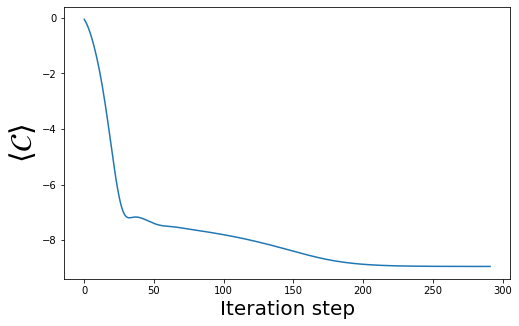

In [8]:
fig, ax = plt.subplots(figsize=[8,5])
ax.plot(costs)
ax.set_xlabel('Iteration step', fontsize=20)
ax.set_ylabel(r'$\langle \mathcal{C} \rangle $', fontsize=30)

In [9]:
gammas, betas = np.split(angles, 2)

In [10]:
gammas[0] # \gamma _1

0.23917160615017577

In [11]:
gammas[1] # \gamma _2

0.4390927438019701

In [12]:
betas[0] # \beta _1

-0.5325052203000568

In [13]:
betas[1] # \beta _2

-0.28623640252096283

Initialize an RBM ansatz with $N=12$ visible units, the same number as the underlying graph

In [26]:
logpsi = RBM(len(G))

Exactly apply $U_C (\gamma _1) = \exp \left( -i \gamma _1 \sum _{\langle i, j \rangle } Z_i Z_j \right)$

In [27]:
logpsi.UC(G, gamma=gammas[0], mask=False)

The process introduced a number of hidden units $n_h$ that's equal to the number of edges in the graph. (Plus 1 that was there by default when we initialized the RBM.)

We can look at the numbers:

In [28]:
logpsi.nv, logpsi.nh

(12, 19)

In [29]:
logpsi.alpha # = logpsi.nh / logpsi.nv

1.5833333333333333

## The first optimization

Now, initialize the optimizer and approximately apply $U_B (\beta _1) = \exp \left( -i \beta _1 \sum _i X_i \right)$

In [30]:
optim = Optimizer(logpsi, n_steps=600, n_chains=4, warmup=800, step=12)

In [31]:
%%time

for n in range(len(G)):
    params, history = optim.sr_rx(n=n, beta=betas[0], resample_phi=3, verbose=True)
    optim.machine.params = params
    
    print(f'Done with qubit #{n+1}, reached fidelity {history[-1]}')

Done with qubit #1, reached fidelity 0.9993299426010899
Done with qubit #2, reached fidelity 0.9986955450559947
Done with qubit #3, reached fidelity 0.9975979274451514
Done with qubit #4, reached fidelity 0.9996740910365423
Done with qubit #5, reached fidelity 1.000233711957504
Done with qubit #6, reached fidelity 0.9990554834675698
Done with qubit #7, reached fidelity 0.9980714767867275
Done with qubit #8, reached fidelity 0.9953870216038553
Done with qubit #9, reached fidelity 0.9971440242775572
Done with qubit #10, reached fidelity 0.9962283801399214
Done with qubit #11, reached fidelity 0.9978881849846221
Done with qubit #12, reached fidelity 0.9973344147499051
CPU times: user 2min 18s, sys: 9.59 s, total: 2min 28s
Wall time: 1min 24s


In [32]:
logpsi.params = params

It's a good check to compare exact fidelities at this point:

In [33]:
psi_exact = QAOA(G, p=1).simulate(gammas[0], betas[0]).final_state_vector
psi_rbm = logpsi.get_state_vector(normalized=True)

In [34]:
exact_fidelity(psi_exact, psi_rbm)

0.9744542765146598

Next, apply $U_C (\gamma _2) = \exp \left( -i \gamma _2 \sum _{\langle i, j \rangle } Z_i Z_j \right)$

In [35]:
logpsi.UC(G, gamma=gammas[1], mask=False)

However, this doubled the number of hidden units:

In [36]:
logpsi.alpha

3.0833333333333335

## The compression step

We can keep the number of hidden units under control as we go to higher values of $p$ by  performing a compression step, as described in the paper.

Essentially, we define a smaller RBM with `RBM.alpha = 1.5` (the previous value or any we choose to compress to). Then, we optimize parameters of the new RBM to describe the same quantum state as the larger one, obtaining a compressed representaion of

$$  \vert \psi \rangle = U_C (\gamma _2) \; U_B (\beta _1) \; U_C(\gamma _1) \; \vert + \rangle  $$

A heuristically good choice for initial RBM parameters are those values that exactly describe the following quantum state:

$$ \vert \psi _\text{init} \rangle = U_C (\gamma_1 + \gamma _2) \; \vert + \rangle  $$

In [37]:
aux = RBM(len(G))
aux.UC(G, gammas[0] + gammas[1], mask=False)
init_params = aux.params

Now, perform the compression:

In [38]:
%%time
params, history = optim.sr_compress(init=init_params, resample_phi=2, verbose=True)

Iteration   42 | Fidelity = 0.9485 | lr = 0.100 | Diff mean fidelity = 0.0755017
CPU times: user 26.3 s, sys: 1.78 s, total: 28.1 s
Wall time: 16 s


Let's plot the fidelity as a function of compression optimizer step:

Text(0, 0.5, 'Fidelity')

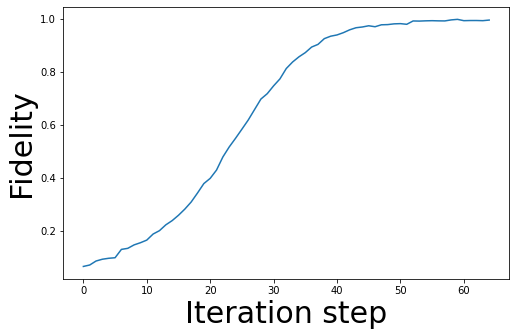

In [39]:
fig, ax = plt.subplots(figsize=[8,5])
ax.plot(history)
ax.set_xlabel('Iteration step', fontsize=30)
ax.set_ylabel('Fidelity', fontsize=30)

In [59]:
nv = logpsi.nv
nh = (len(params) - nv)//(nv+1)

state_dict = OrderedDict([('C', logpsi.C),
                          ('a', params[:nv]),
                          ('b', params[nv:(nv+nh)]),
                          ('W', params[(nv+nh):].reshape(nv,-1))])

In [60]:
logpsi.state_dict = state_dict

Estimated fidelity reached:

In [61]:
history[-1]

0.996055297734952

In [62]:
logpsi.alpha

1.5833333333333333

Finally, we can apply $U_B (\beta _2) = \exp \left( -i \beta _2 \sum _i X_i \right)$

In [63]:
optim.machine = logpsi

## The second optimization

In [64]:
%%time

for n in range(len(G)):
    params, history = optim.sr_rx(n=n, beta=betas[1], resample_phi=3, verbose=True)
    optim.machine.params = params
    
    print(f'Done with qubit #{n+1}, reached fidelity {history[-1]}')

Done with qubit #1, reached fidelity 0.9973038658085185
Done with qubit #2, reached fidelity 0.9923901778482376
Done with qubit #3, reached fidelity 0.993090261530762
Done with qubit #4, reached fidelity 0.9971415118267768
Done with qubit #5, reached fidelity 0.9922043152238704
Done with qubit #6, reached fidelity 0.9959841511077027
Done with qubit #7, reached fidelity 0.9940817589292382
Iteration   24 | Fidelity = 0.9941 | lr = 0.100 | Diff mean fidelity = 0.0002406
Done with qubit #8, reached fidelity 0.9940698114987169
Done with qubit #9, reached fidelity 0.9933160708294844
Done with qubit #10, reached fidelity 0.9852644847803934
Done with qubit #11, reached fidelity 0.9959829458056728
Done with qubit #12, reached fidelity 0.9860826105607964
CPU times: user 1min 54s, sys: 8.33 s, total: 2min 2s
Wall time: 1min 28s


And, compare the final output fidelity at $p=2$:

In [65]:
logpsi.params = params 

In [66]:
psi_exact = QAOA(G, p=2).simulate(gammas, betas).final_state_vector
psi_rbm = logpsi.get_state_vector(normalized=True)

In [67]:
exact_fidelity(psi_exact, psi_rbm)

0.9342733929570779